In [1]:
# Imports
import soothsayer as sy
import numpy as np
import pandas as pd

%matplotlib inline

In [20]:
# Load data
X_iris = sy.read_dataframe("./data/X_iris.pbz2")
y_iris = sy.read_dataframe("./data/y_iris.labels.tsv.gz").iloc[:,0]
c_iris, class_colors = sy.utils.map_colors(y_iris, mode=4)

# Add noise data
def create_noise_attributes(X, n_attrs_total=100, random_state=0, concat=True, **kws):
    assert n_attrs_total > X.shape[1], f"{n_attrs_total} < X.shape[1] = {X.shape[1]}"
    n_attrs_to_add = n_attrs_total - X.shape[1]
    df_noise = pd.DataFrame(
        data = np.random.RandomState(random_state).normal(size=(X.shape[0], n_attrs_to_add), **kws),
        index=X.index,
        columns=[*map(lambda j:f"noise_{j}", range(n_attrs_to_add))]
    )
    if concat:
        return pd.concat([X, df_noise], axis=1)
    else:
        return df_noise
X_iris_noise = create_noise_attributes(X_iris).abs()
X_norm = sy.transmute.normalize(X_iris_noise, method="zscore", axis=0)

Running computational pipeline:
eigendecomposition	0.0061262 s
dissimilarity	0.19718 s


Inferred mode as `dissimilarity`


cluster	0.20465 s
dendrogram	0.21016 s
convert_to_tree	0.2217 s
convert_to_graph	0.22878 s

      /-virginica
   /y2
-y1   \-setosa
  |
   \-versicolor


(<Figure size 936x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c203e16a0>)

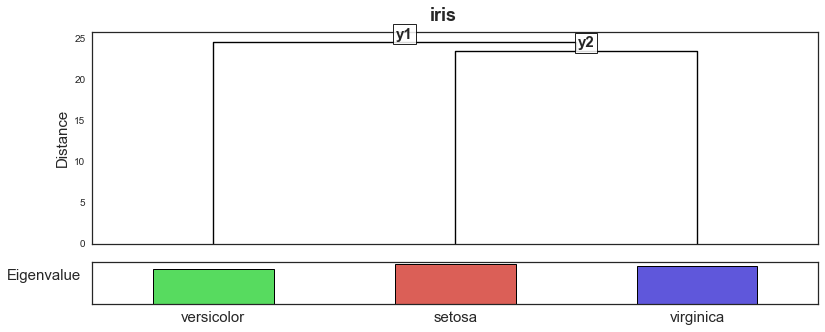

In [3]:
# Get the topology of the data
topology_iris = sy.Topology(
    X=X_norm, 
    y=y_iris,
    name = "iris",
    class_type="species",
    attr_type="leaf length",
    obsv_type="sample",
    class_colors=class_colors,
)

# Target matrix
Y_iris = topology_iris.get_target_matrix()

# Show structure with ascii
print(topology_iris.get_ascii())

# Plot dendrogram with submodels
topology_iris.plot_topology()

In [15]:
%%time
# Select best features for each task
d_submodel_featureextraction = OrderedDict()
for submodel in Y_iris.columns:
    # Instantiate feature selection (Clairvoyant)
    clr_submodel = Clairvoyant(
        n_iter=10,
        name=submodel, 
        model_type="tree", 
        attr_type=topology_iris.attr_type,
        class_type=topology_iris.class_type,
        n_jobs=1,
        metadata = {"model_version":"v1"}
    )
    # Training data
    y_query = Y_iris[submodel].dropna()
    X_query = X_norm.loc[y_query.index,:]
    # Fit the model and bootstrap samples 
    clr_submodel.fit(X=X_query, y=y_query)
    # Cross-validat to find best weights
    clr_submodel.cross_validate(early_stopping=10)
    # Store the data
    d_submodel_featureextraction[submodel] = clr_submodel


Permuting samples and fitting models: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]

Cross validating model subsets:  10%|█         | 10/99 [00:02<00:25,  3.50it/s]Early stopping at iteration=10 with maximum score= 0.9533333333333334


Permuting samples and fitting models: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]

Cross validating model subsets:  10%|█         | 10/99 [00:02<00:25,  3.49it/s]Early stopping at iteration=10 with maximum score= 1.0



CPU times: user 6.04 s, sys: 1.31 s, total: 7.35 s
Wall time: 9.65 s


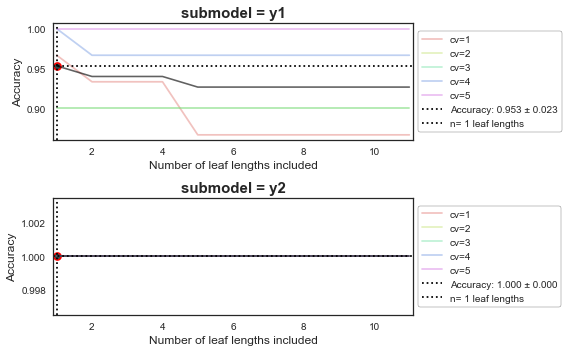

In [18]:
# Show performance of feature selection
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(figsize=(8,5), nrows=Y_iris.shape[1])
    for i, (submodel, clr_submodel) in enumerate(d_submodel_featureextraction.items()):
        clr_submodel.plot_scores(title=f"submodel = {submodel}", ax=ax[i])
fig.tight_layout()